# Note
This notebook is to train the encoder as a classifier with the idea of validate the encoder architecture first and then use this to train the VAE.

# Parameters to experiment

In [5]:
# training on guanaco
# ATENTION: if it is going to run on guanaco, so comment the %matplotlib magic in next block
trainingOnGuanaco = False

# train without notebook
trainWithJustPython = False

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 7
number_experiment = str(number_experiment)

# add general comment about experiment 
comment = "encoder as clasifier with periodic + variable (with class balancing)"

In [2]:
# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64

# periodic
# only_these_labels = [16, 92, 53]

# periodic + variable
only_these_labels = [16, 92, 53, 88, 65, 6]
# 53 has 24 light curves

# only_these_labels = [16, 92]
# only_these_labels = [16, 92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

# training
epochs = 5

# band
# passband = 5
passband = 5

batch_training_size = 128

In [3]:
# training params
learning_rate = 1e-3

# Import libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

# %matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

import math

from torch import nn

# local imports
%load_ext autoreload
%autoreload 2
sys.path.append('../models')
from classifier import EncoderClassifier

sys.path.append("./aux/")
from auxFunctions import *

# Load data

In [5]:
# define path to dataset
pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticc_torch-master/"

## Loading dataset with pytorch tool

In [6]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 2 csv files at given path
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_test_set_batch1.csv


# Spliting data (train/test)

In [7]:
# Spliting the data

# print(torch_dataset_lazy.__len__())

# selecting train splitting
train_size = int(0.8 * torch_dataset_lazy.__len__())
#print(train_size)

# getting test splitting
validation_size = math.floor((torch_dataset_lazy.__len__() - train_size)/2)
#print(validation_size)

# getting test splitting
test_size = torch_dataset_lazy.__len__() - train_size - validation_size
#print(test_size)

# spliting the torch dataset
trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(torch_dataset_lazy, [train_size, validation_size, test_size])

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
print("sum: ", train_size+ validation_size + test_size)

train size: 2620
validation size:  328
test size: 328
sum:  3276


## Create a dataloader

initila distribution


<BarContainer object of 6 artists>

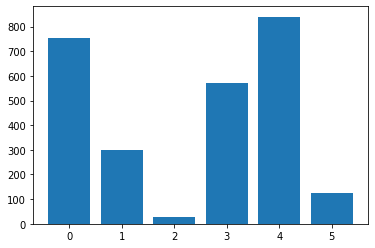

In [8]:
print("initila distribution")
initialClassesDistribution = countClasses(trainDataset, only_these_labels)

fig, ax = plt.subplots()
ax.bar(x = np.arange(len(only_these_labels)), height = initialClassesDistribution)

In [9]:
# # Create data loader (minibatches)

# training loader
trainLoader = torch.utils.data.DataLoader(
    trainDataset, 
    batch_size = batch_training_size, 
    # to balance classes
    sampler=ImbalancedDatasetSampler(trainDataset),
)

# validation loader
validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size= batch_training_size,  num_workers = 4)

# # test loader
testLoader = torch.utils.data.DataLoader(testDataset)
# trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

balanced distribution


<BarContainer object of 6 artists>

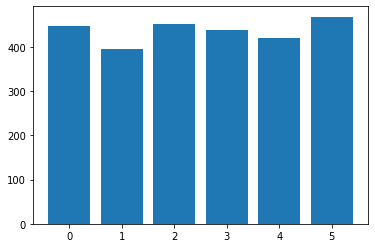

In [10]:
print("balanced distribution")
balancedClassesDistribution = countClasses(trainLoader, only_these_labels)

fig, ax = plt.subplots()
ax.bar(x = np.arange(6), height = balancedClassesDistribution)
# ax.bar(x = only_these_labels, height = temp2, width = 10)

## Load the path to save model while training

In [11]:
import os

# create experiment's folder
folder_path = ("/home/lbravo/thesis/work/thesis/experiments/" + number_experiment) if trainingOnGuanaco else ("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment)
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# check if folder exists
if not(os.path.isdir(folder_path)):
        
    # create folder
    try:
        os.mkdir(folder_path)
    except OSError:
        print ("Creation of the directory %s failed" % folder_path)
    else:
        print ("Successfully created the directory %s " % folder_path)
else:
    print("folder already exists")

# define paht to save model while training
pathToSaveModel = "/home/lbravo/thesis/thesis/work/thesis/experiments/" + number_experiment + "/model" if trainingOnGuanaco else "/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/model"

folder already exists


In [12]:
# store varibales on file
text_file = open("../experiments/" + number_experiment + "/experimentParameters.txt", "w")
text = "N° experiment: {7}\n General comment: {13}\n Classes: {0}\n train_size: {9}\n validation_size: {10}\n test_size: {11}\n total dataset size: {12}\n Epochs: {8}\n Latent dimension: {1}\n Hidden dimension: {2}\n Input dimension: {3}\n Passband: {4}\n Learning rate: {5}\n Batch training size: {6}\n initial train classes distribution: {14}\nbalanced train class distribution: {15}".format(only_these_labels, latentDim, hiddenDim, inputDim, passband, learning_rate, batch_training_size, number_experiment, epochs, train_size, validation_size, test_size, train_size + validation_size + test_size, comment, initialClassesDistribution, balancedClassesDistribution)
text_file.write(text)
text_file.close()
print("experiment parameters file created")

experiment parameters file created


## Defining parameters to Autoencoder

In [13]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

passband = passband

num_classes = len(only_these_labels)


# defining model
model = EncoderClassifier(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim, num_classes = num_classes)

# mdel to GPU
model = model.cuda()

In [14]:
print(model)

EncoderClassifier(
  (pconv1): PartialConv(
    (input_conv): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(1, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (hidden1): Linear(in_features=1632, out_features=100, bias=True)
  (outputLayer): Linear(in_features=100, out_features=6, bias=True)
  (activationConv): ReLU()
  (activationLinear): Tanh()
)


### Training

starting the training
epoch:    0 / 5
early stopping counter:  2
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    1 / 5
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    2 / 5
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    3 / 5
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    4 / 5
New min test loss. Saving model
saving losses
saving f1 scores
training has finished


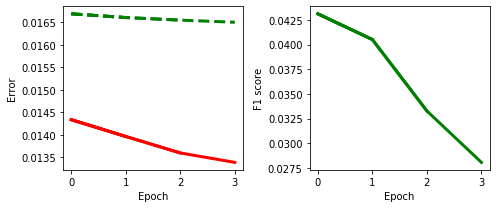

In [15]:
from sklearn.metrics import f1_score

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.5)

# loss function
lossFunction = nn.CrossEntropyLoss()

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# f1 scores
f1Scores = np.zeros((epochs, ))

# min global test loss 
minTestLossGlobalSoFar = float("inf")

# # # loss plot
# if it is not cluster
if (not trainingOnGuanaco) or (not trainWithJustPython):
    
    # add f1 and loss plots
    fig, ax = plt.subplots(1, 2, figsize = (7, 3), tight_layout = True)
    # # fig, ax = plt.subplots()
    
    # error
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Error")
    
    
    # f1 score
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("F1 score")
    

# early stopping
prior_test_error = 0
count_early_stop = 0
threshold_early_stop = 20


print("starting the training")


# epoch
for nepoch in range(epochs):
        
    print("epoch:    {0} / {1}".format(nepoch, epochs))
    
    
    
     
    ######## Train ###########
    epoch_train_loss = 0
    
    for data_ in trainLoader:
        
        data = data_[0]
        labels = data_[1].cuda()
        
        optimizer.zero_grad()
            
        # this take the deltas (time and magnitude)
        data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()

        # get model output
        outputs = model.forward(data)
        
        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).cuda())
        
        # backpropagation
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # add loss value (of the currrent minibatch)
        epoch_train_loss += loss.item()
        

    # get epoch loss value
    train_loss[nepoch] = epoch_train_loss / train_size
    
    
    
    
    ##### Validation ########
    
    epoch_test_loss = 0
    
    # check f1 score in each minibatch
    f1Score = 0
    
    batchCounter = 0
    
    # minibatches
    for data_ in validationLoader:
        
        data = data_[0]
        labels = data_[1].cuda()
        
        data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()
        
        outputs = model.forward(data)
        
        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).cuda())
    
        #  store minibatch loss value
        epoch_test_loss += loss.item()
        
        # f1 score
        f1Score += f1_score(mapLabels(labels, only_these_labels).cpu().numpy(), torch.argmax(outputs, 1).cpu().numpy(), average = "micro")
        
        # batch counter
        batchCounter += 1
    
    # get epoch test loss value
    test_loss[nepoch] = epoch_test_loss / validation_size
    
    # get epoch f1 score
    f1Scores[nepoch] = f1Score / batchCounter
    
    
    
    
    # plot loss values
    # if it's not cluster
    if (not trainingOnGuanaco) or (not trainWithJustPython):

        # loss values
        ax[0].plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
        ax[0].plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green")
        
        # f1 score values
        ax[1].plot(f1Scores[0: nepoch], linewidth = 3, c = "green")
        
        # plot
        fig.canvas.draw()
    
    
    #### Early stopping #####
    
    
    
    # if new test loss is greater than the older one
    count_early_stop += 1
    if epoch_test_loss > prior_test_error:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
    else: 
        count_early_stop = 0
    
    # update prior test error
    prior_test_error = epoch_test_loss
    
    # analyze early stopping
    if count_early_stop > threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        text_file = open("../experiments/" + number_experiment + "/earlyStopping.txt", "w")
        metricsText = "Epoch: {0}\n ES counter: {1}\n, Reconstruction test error: {2}".format(nepoch, count_early_stop, epoch_test_loss)
        text_file.write(metricsText)
        text_file.close()
        break
        
        
        
    #### Saving best model ####
    
    # if epoch test loss is smaller than global min
    if test_loss[nepoch] < minTestLossGlobalSoFar:
        
        # update global min
        minTestLossGlobalSoFar = test_loss[nepoch]
        
        # save model
        saveBestModel(model, pathToSaveModel, number_experiment, nepoch, minTestLossGlobalSoFar)
                
   


    # save losses
    print("saving losses")
    losses = np.asarray([train_loss, test_loss]).T
    np.savetxt("../experiments/" + number_experiment + "/training_losses.csv", losses, delimiter=",")
    

    
    
    # save f1 scores
    print("saving f1 scores")
    np.savetxt("../experiments/" + number_experiment + "/f1Scores.csv", f1Scores, delimiter=",")

    
    
# final message
print("training has finished")

In [16]:
# get metrics on trainig dataset
getConfusionAndClassificationReport(trainLoader, nameLabel = "Train", passband = passband, model = model, staticLabels = only_these_labels, number_experiment = number_experiment)


# get metrics on validation dataset
getConfusionAndClassificationReport(validationLoader, nameLabel = "Validation", passband = passband, model = model, staticLabels = only_these_labels, number_experiment = number_experiment)

saving confusion matrix scores
saving clasification report


/home/leo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


saving confusion matrix scores
saving clasification report


### Stop execution if it's on cluster

In [17]:
import sys

if  trainingOnGuanaco or trainWithJustPython:

    sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")

# Analyzing training

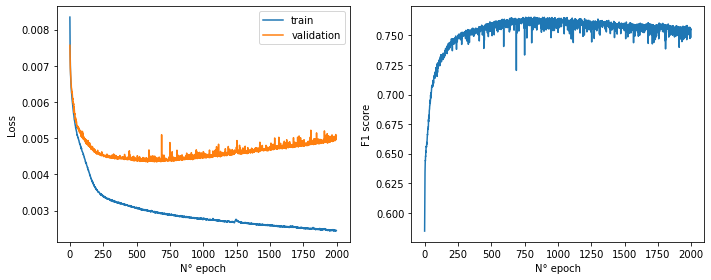

In [6]:
# load losses array
losses = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/training_losses.csv")

# f1 scores
f1Scores = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/f1Scores.csv")

# plot losses
fig, ax = plt.subplots(1, 2, figsize = (10,4), tight_layout = True)

# loss
ax[0].set_xlabel("N° epoch")
ax[0].set_ylabel("Loss")
ax[0].plot(losses.iloc[:, 0], label = "train")
ax[0].plot(losses.iloc[:, 1], label = "validation")
# ax[0].scatter(429, 0.000845159766508081, c = "r", linewidths = 10)
ax[0].legend()

# f1 scores
ax[1].set_xlabel("N° epoch")
ax[1].set_ylabel("F1 score")
ax[1].plot(f1Scores)
# ax[1].scatter(429, f1Scores.iloc[428], c = "r", linewidths = 10)


# ax[0].scatter(429, 0)

In [14]:
!cat ../experiments/7/bestScoresModelTraining.txt

Epoch: 585
 Reconstruction test error: 0.00434128265165168

In [15]:
# confusion matrix
import pandas as pd
import seaborn as sn

# get confusion matrix
# cm = pd.read_csv('../experiments/' + number_experiment + '/confusionMatrixTrain.csv', header = None) 
cm = pd.read_csv('../experiments/' + number_experiment + '/confusionMatrixValidation.csv', header = None) 

sn.heatmap(cm, annot=True)

FileNotFoundError: [Errno 2] File ../experiments/7/confusionMatrixValidation.csv does not exist: '../experiments/7/confusionMatrixValidation.csv'

In [16]:
# classification report
!cat ../experiments/7/clasificationReportTrain.txt

cat: ../experiments/7/clasificationReportTrain.txt: No existe el archivo o el directorio


In [22]:
# classification report
!cat ../experiments/8/clasificationReportValidation.txt

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        84
         1.0       1.00      0.03      0.06        34
         2.0       0.03      1.00      0.07         5
         3.0       0.00      0.00      0.00        95
         4.0       0.00      0.00      0.00        99
         5.0       0.02      0.27      0.03        11

    accuracy                           0.03       328
   macro avg       0.18      0.22      0.03       328
weighted avg       0.10      0.03      0.01       328
